In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
import yfinance as yf

data = yf.download(tickers = "NEM", start="2017-12-01", end="2023-06-16", interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,37.070000,37.610001,36.779999,37.189999,31.313108,5074400
2017-12-04,37.240002,37.240002,36.660000,36.840000,31.018410,3777300
2017-12-05,36.599998,36.799999,36.070000,36.200001,30.479544,5984100
2017-12-06,36.250000,36.400002,35.779999,35.830002,30.168015,5797400
2017-12-07,35.529999,36.130001,35.450001,35.919998,30.307228,4047700
...,...,...,...,...,...,...
2023-06-09,41.930000,42.009998,41.290001,41.459999,41.459999,5601300
2023-06-12,41.400002,42.070000,41.279999,42.040001,42.040001,6618100
2023-06-13,42.250000,42.549999,42.090000,42.439999,42.439999,7955900


In [3]:
data = data.reset_index('Date', inplace=False)

In [4]:
# 2. Đọc file dữ liệu giá vàng GC=F và chia train test validate theo tỉ lệ 7:2:1
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [6]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
#y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
#y_pred_val =  model.predict(n_periods=len(y_val))

In [7]:
# Chọn kernel tốt nhất
kernels = [RBF(), Matern(), RationalQuadratic(), ExpSineSquared(), DotProduct()]
param_grid = {'kernel': kernels}

gpr = GaussianProcessRegressor()
grid_search = GridSearchCV(gpr, param_grid, cv=KFold(n_splits=5))

grid_search.fit(x_train, y_train)


print("Best Kernel:", grid_search.best_estimator_.kernel)
print("Best Score:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The op

Best Kernel: RationalQuadratic(alpha=1, length_scale=1)
Best Score: -4.9600140072963566


In [8]:
# Tạo mô hình GPR
kernel = RationalQuadratic(alpha=1, length_scale=1)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)

In [9]:
gpr.fit(x_train, y_train)

GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1),
                         random_state=42)

In [10]:
y_pred = gpr.predict(x_test)

In [11]:
y_pred_val =  gpr.predict(x_val)

In [12]:
# 12. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 14.964620511705792
Validation RMSE: 4.814166403800761
Testing MAE: 11.202006085133547
Validation MAE: 3.903117290538096
Testing MAPE: 0.16926843926456678
Validation MAPE: 0.07902853026294286


In [13]:
last_index =  data.index[-1]
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = gpr.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[42.78791667 42.7757941  42.76369791 42.75162801 42.73958427 42.72756661
 42.71557491 42.70360907 42.69166899 42.67975457 42.66786571 42.6560023
 42.64416425 42.63235146 42.62056382 42.60880124 42.59706361 42.58535086
 42.57366286 42.56199954 42.55036079 42.53874652 42.52715663 42.51559104
 42.50404964 42.49253234 42.48103905 42.46956969 42.45812415 42.44670234]


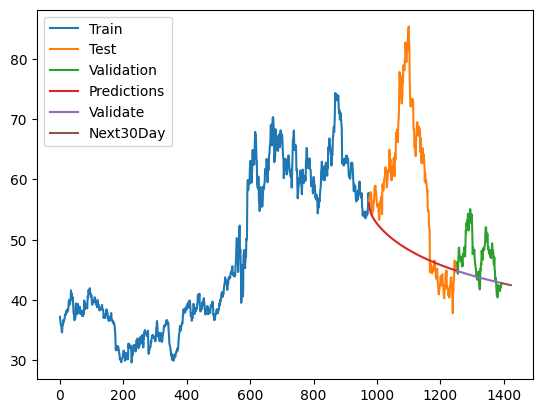

In [14]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()